**Before starting:**

You need to install Basemap. Do it only once.

In [ ]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 4.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.


**Goal of this practice:**

In this second practice, we will use the "BigQuery" technology which uses a network of computers at Google. We still use the Google Colab to run this Jupyter notebook and interact with the Google Cloud Platform. We will work directly on the whole database (1998-2015, 150Go) and you will perform basic statistics. The idea is to show that BigQuery is able to manage very large datasets efficiently (few seconds). We will manipulate the SST/SSH dataset with BigQuery using the magic command *%%bigquery*.

**Import libraries:**

- matplotlib (2D plotting)
- pylab (scientific computing)
- basemap (plotting 2D data on maps)
- scikit-learn (machine learning)
- pandas (data structures and data analysis tools)

In [ ]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(15,15) # graph size

Populating the interactive namespace from numpy and matplotlib


**Declare functions:**
- plot_im (plot satellite image with geographic coordinates)
- plot_ts (plot time series)

In [ ]:
# function to plot images  
def plot_im(lon,lat,im,size_points,var_name):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='robin',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    #im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)
    
# function to plot time series
def plot_ts(time,ts,line_type,var_name):

    # plot
    plot_date(time,ts,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

**Connection to the GCP:**

First, we have to connect to the Google Cloud Platform. Enter the login "bigdataocean2020@gmail.com" and password "bdoimt2023". Do it only once. We will maybe need an authentication: contact me at pierre.tandeo@imt-atlantique.fr.

In [ ]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

from google.colab import auth
auth.authenticate_user()

The Google Cloud Platform has set up a tool to handle large databases. This is called "BigQuery" and it is based on the NoSQL ("Not only SQL") language. The syntaxe in BigQuery is very similar to the pandas example given in the first practice. SQL language is suitable to manipulate and compute basic statistics such as the mean, standard deviation, minimum, maximum, correlation, etc... Here you will find the list of basic functions: https://cloud.google.com/bigquery/docs/reference/legacy-sql?hl=fr.

In the example below, we plot the mean SST map in the Mediterranean Sea over the period 1998-2015. The full 18-years dataset is stored in the BigQuery table *bdo2020.bdo2020.1998_2015*. The project is called *alert-ground-261008* (strange but you have to provide it). The result of the BigQuery request is stored in the *output* dataframe. 

In [ ]:
%%bigquery output --project alert-ground-261008
SELECT lon, lat, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.1998_2015
WHERE lon>0 AND lon<35 AND lat>30 AND lat<45
GROUP BY lon, lat

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# sample of the dataframe
output

,lon,lat,mean_sst
0,18.125,35.375,21.216261
1,18.875,36.375,20.996098
2,16.375,37.125,20.941930
3,0.875,37.375,20.044828
4,1.125,37.625,20.053019
...,...,...,...
1718,11.375,40.875,19.792352
1719,4.625,41.625,18.134129
1720,4.625,42.125,17.657890
1721,5.375,42.375,17.617382


Text(0.5, 1.0, 'Mean over the years 1998-2015')

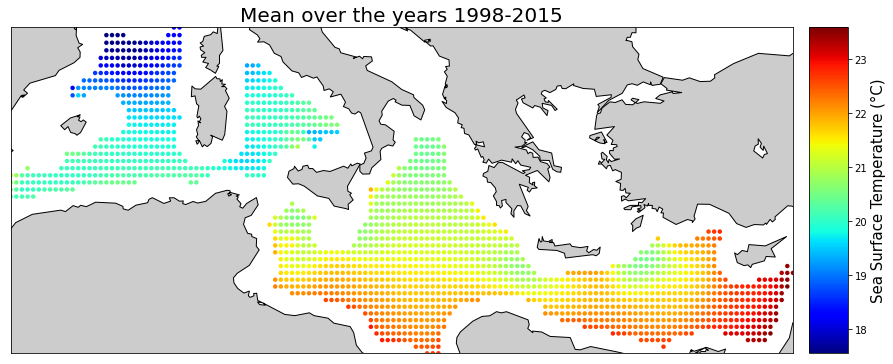

In [ ]:
plot_im(output.lon, output.lat, output.mean_sst, 20, 'Sea Surface Temperature (°C)')
title('Mean over the years 1998-2015', size=20)

**Part 1)**

Plot the global maps of mean SST, mean SSH and correlation SST/SSH for the period 1998-2015.

In [ ]:
%%bigquery output --project alert-ground-261008
SELECT lon, lat, AVG(sst) AS mean_sst, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
GROUP BY lon, lat

Query is running:   0%|          |

Downloading:   0%|          |

Text(0.5, 1.0, 'SST mean over the years 1998-2015')

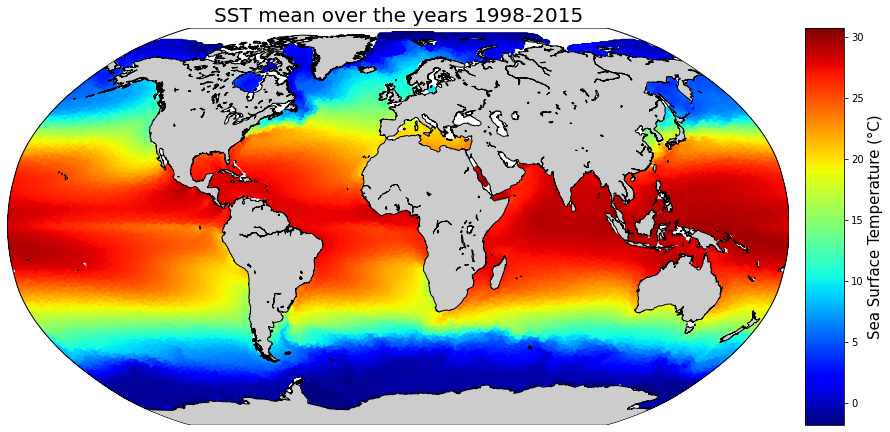

In [ ]:
plot_im(output.lon, output.lat, output.mean_sst, 20, 'Sea Surface Temperature (°C)')
title('SST mean over the years 1998-2015', size=20)

Text(0.5, 1.0, 'SSH mean over the years 1998-2015')

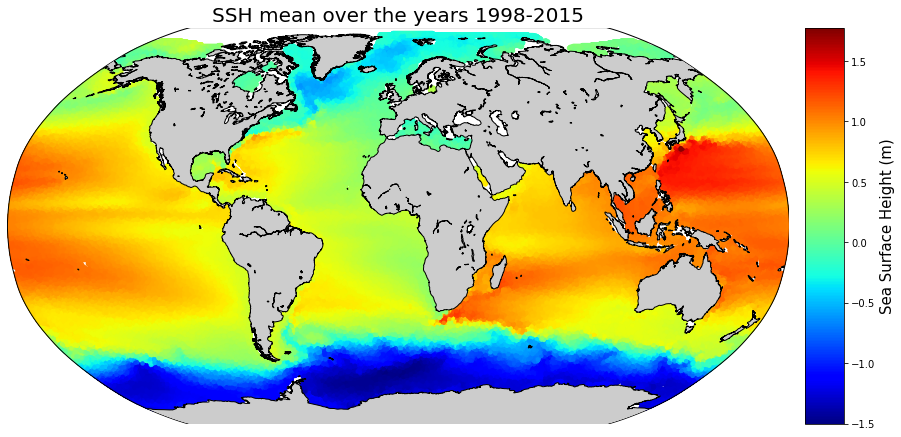

In [ ]:
plot_im(output.lon, output.lat, output.mean_ssh, 20, 'Sea Surface Height (m)')
title('SSH mean over the years 1998-2015', size=20)

Text(0.5, 1.0, 'SST/SSH correlation map over the years 1998-2915')

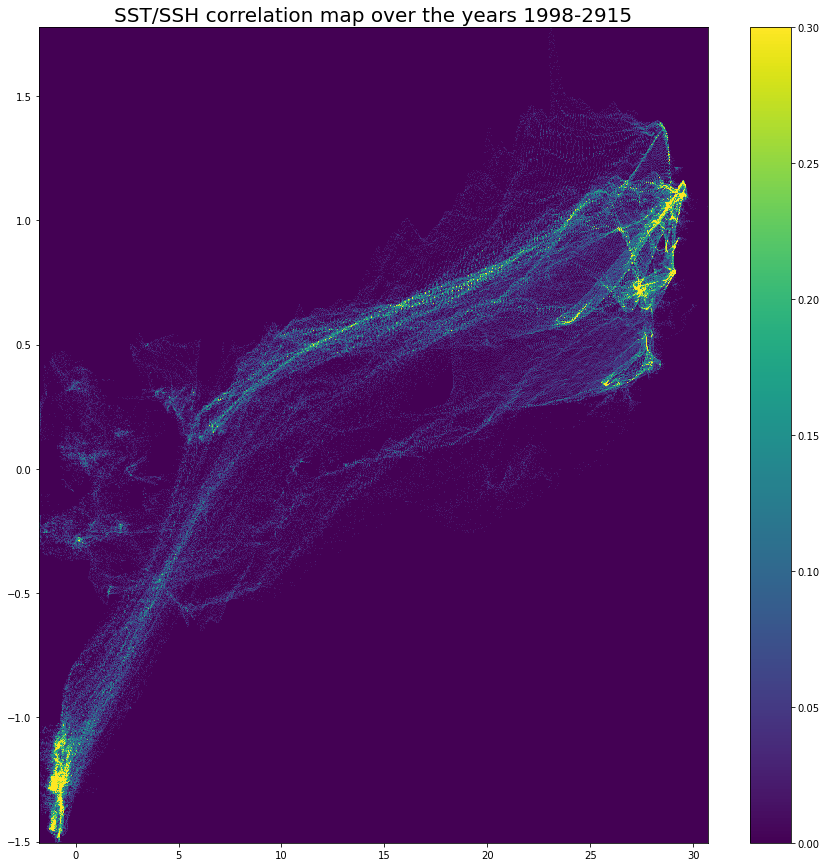

In [ ]:
plt.hist2d(output.mean_sst, output.mean_ssh, bins=[1000, 1000], density=True, vmax=0.3)
plt.colorbar()
plt.title("SST/SSH correlation map over the years 1998-2915", size=20)

In [ ]:
%%bigquery output_1_corr --project alert-ground-261008
SELECT lon, lat, CORR(sst, ssh) AS corr_sst_ssh
FROM bdo2020.bdo2020.1998_2015
GROUP BY lon, lat

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
output_1_corr[output_1_corr.corr_sst_ssh.isna()]

,lon,lat,corr_sst_ssh
39,305.375,-67.375,NaN
127,335.375,-74.875,NaN
748,301.625,-75.125,NaN
749,306.375,-73.875,NaN
848,301.375,-69.125,NaN
...,...,...,...
563891,318.875,-71.125,NaN
563963,350.375,82.625,NaN
563964,302.125,-74.875,NaN
563965,310.875,-73.625,NaN


Text(0.5, 1.0, 'SST/SSH correlation map over the years 1998-2915')

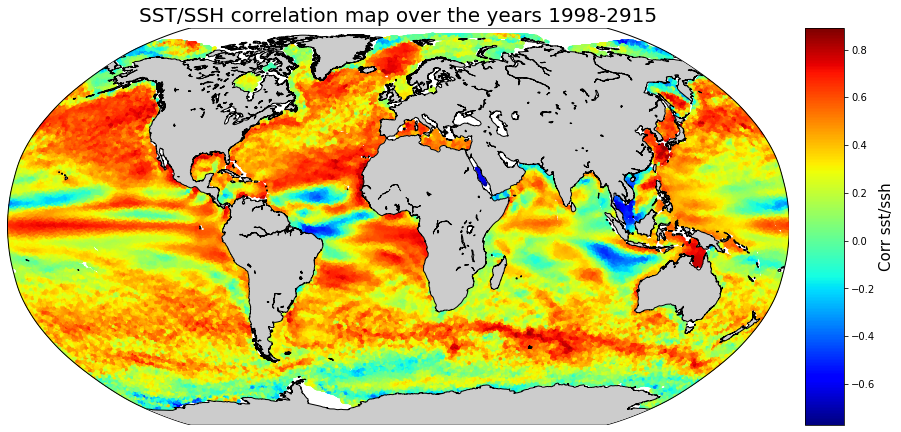

In [ ]:
plot_im(output_1_corr.lon, output_1_corr.lat, output_1_corr.corr_sst_ssh, 10, "Corr sst/ssh")
plt.title("SST/SSH correlation map over the years 1998-2915", size=20)

**Part 2)**

Plot the mean and standard deviation SST time series for the period 1998-2015 in the Equatorial zone between latitudes (-30,+30).

In [ ]:
%%bigquery output_2 --project alert-ground-261008
SELECT time, AVG(sst) AS mean_sst, STDDEV(sst) as stddev_sst
FROM bdo2020.bdo2020.1998_2015
WHERE lat>-30 AND lat<30
GROUP BY time
#ORDER BY time ASC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
output_2.sort_values("time", inplace=True)

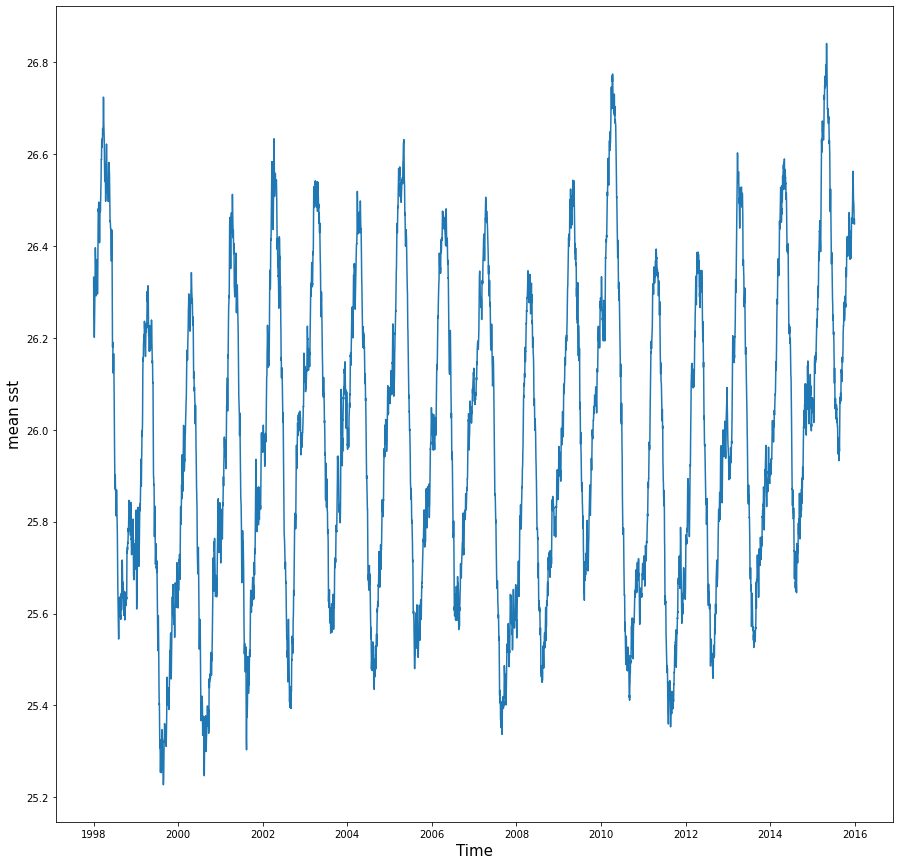

In [ ]:
plot_ts(output_2.time, output_2.mean_sst, "-", "mean sst")

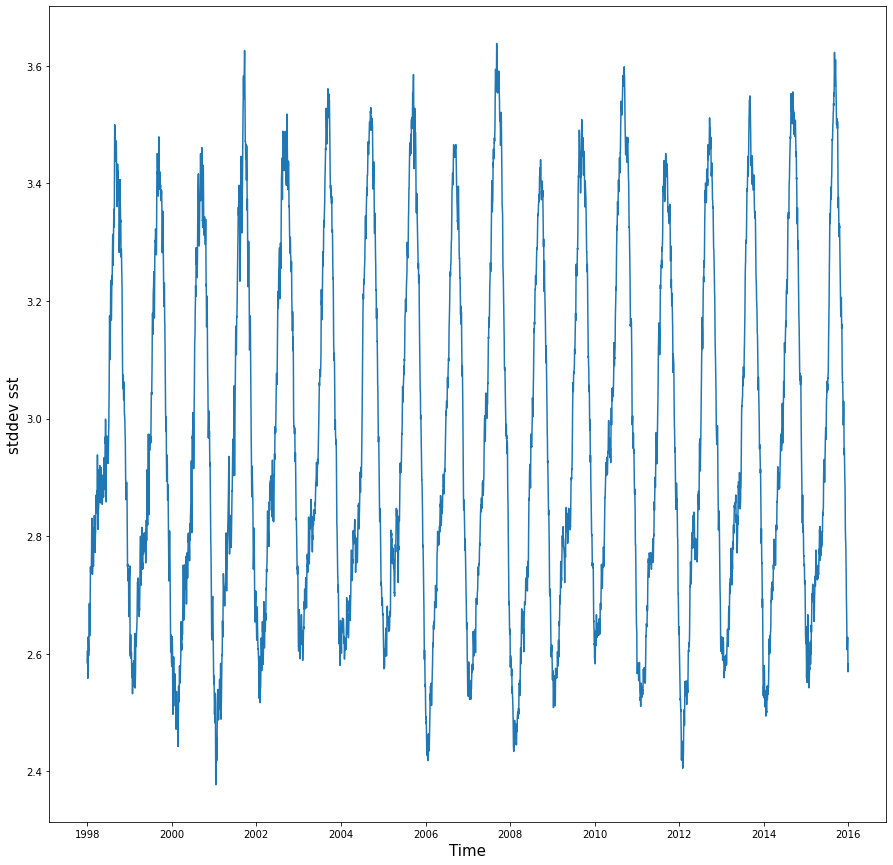

In [ ]:
plot_ts(output_2.time, output_2.stddev_sst, "-", "stddev sst")

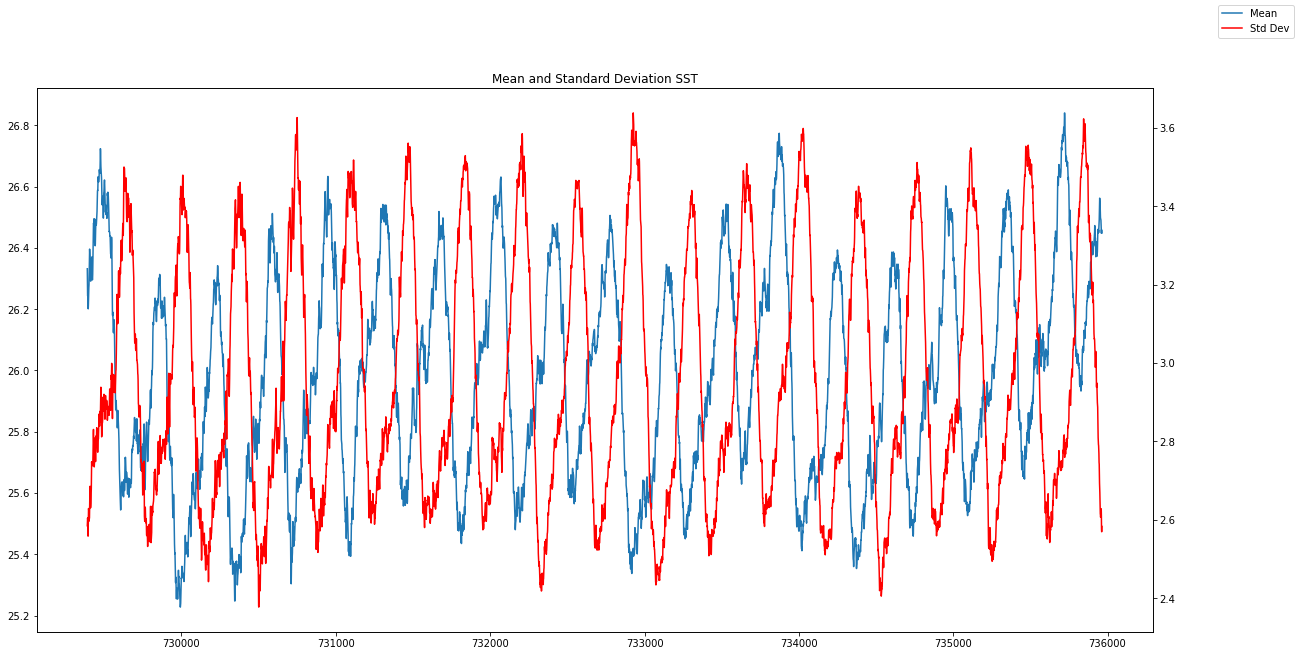

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))

ax1.plot(output_2.time, output_2.mean_sst)
ax1.set_title('Mean and Standard Deviation SST')

ax2 = ax1.twinx()
ax2.plot(output_2.time, output_2.stddev_sst, color="red")
fig.legend(['Mean','Std Dev'])
plt.show()

**Part 3)**

Extract a random sample of data (1%) in the Agulhas current between longitude (+42,+46) and latitude (-40,-36) for the period 1998-2015. Then draw the scatterplot between SST and SSH (use a 2D histogram for a better visualization).

In [ ]:
%%bigquery output_3 --project alert-ground-261008
SELECT sst, ssh
FROM bdo2020.bdo2020.1998_2015 TABLESAMPLE SYSTEM (1 PERCENT)
WHERE lat>-40 AND lat<-36 AND lon>42 AND lon<46 

Query is running:   0%|          |

Downloading:   0%|          |

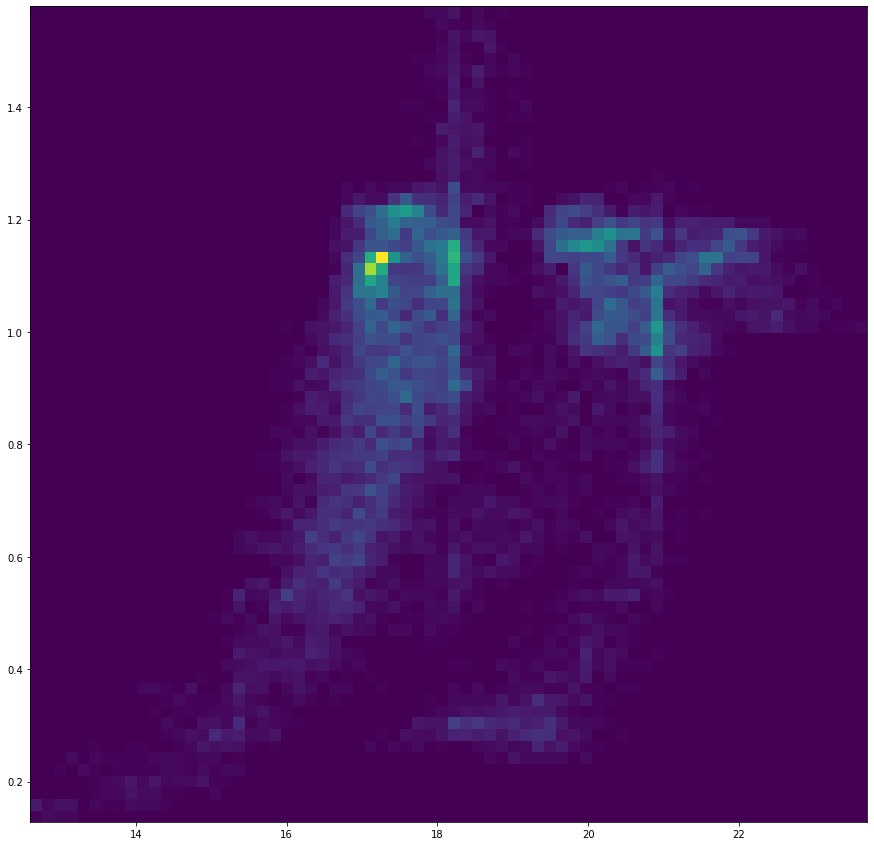

In [ ]:
_ = plt.hist2d(output_3.sst, output_3.ssh, bins=70)

**Part 4)**

Count the number of pixels contaminated by ice every day in the Hudson Bay between longitude (+264,+285) and latitude (+52,+65) for the period 1998-2015.

Be careful, a negative SST doesn't mean that there is ice. There is ice when there is no SST data available.

In [ ]:
%%bigquery output_4 --project alert-ground-261008
SELECT time, COUNT(sst) as ice_count
FROM bdo2020.bdo2020.1998_2015
WHERE lat>52 AND lat<65 AND lon>264 AND lon<285
GROUP BY time

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
output_4.sort_values("time", inplace=True)

In [ ]:
output_4.ice_count = output_4.ice_count/output_4.ice_count.max()

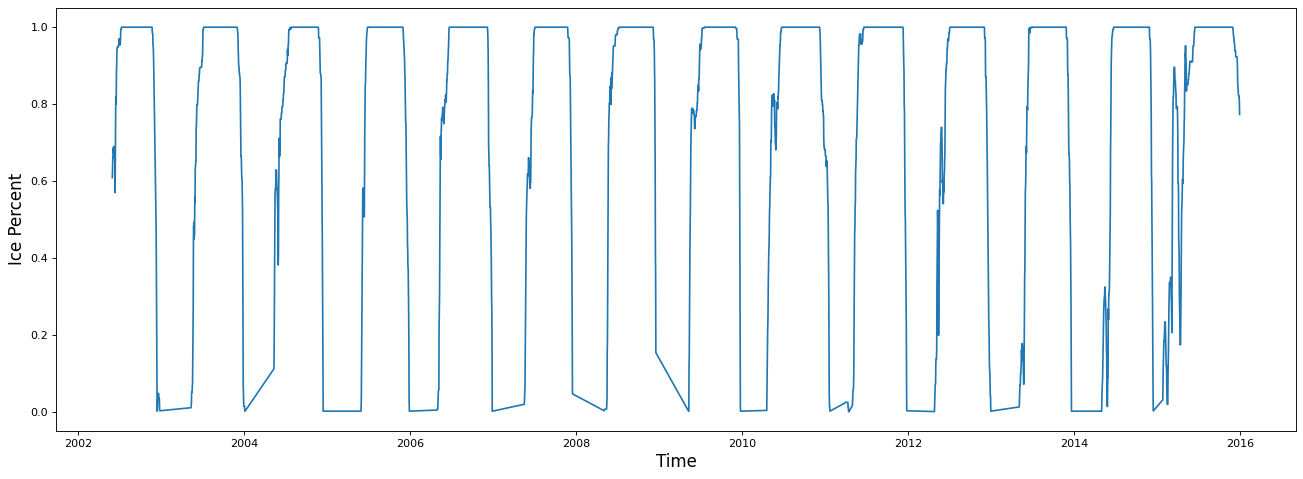

In [ ]:
figure(figsize=(20, 7), dpi=80)
plot_ts(output_4.time, output_4.ice_count.to_list(), "-", "Ice Percent")

**Part 5)**

Compute the mean seasonal cycle of the SST and SSH in the Red Sea, between longitudes (+32,+45) and latitudes (+13,+30), for the period 1998-2015.

In [ ]:
%%bigquery output_5 --project alert-ground-261008
SELECT MOD(CAST(time as INT), 365), AVG(sst) as avg_sst, AVG(ssh) as avg_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lat>13 AND lat<30 AND lon>32 AND lon<45
GROUP BY MOD(CAST(time as INT), 365)

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
#can also do
'''
%%bigquery output_5_2 --project alert-ground-261008
SELECT dayofyear, AVG(sst) as avg_sst, AVG(ssh) as avg_ssh
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lat>13 AND lat<30 AND lon>32 AND lon<45
GROUP BY dayofyear'''

In [ ]:
output_5.sort_values("f0_", inplace=True)

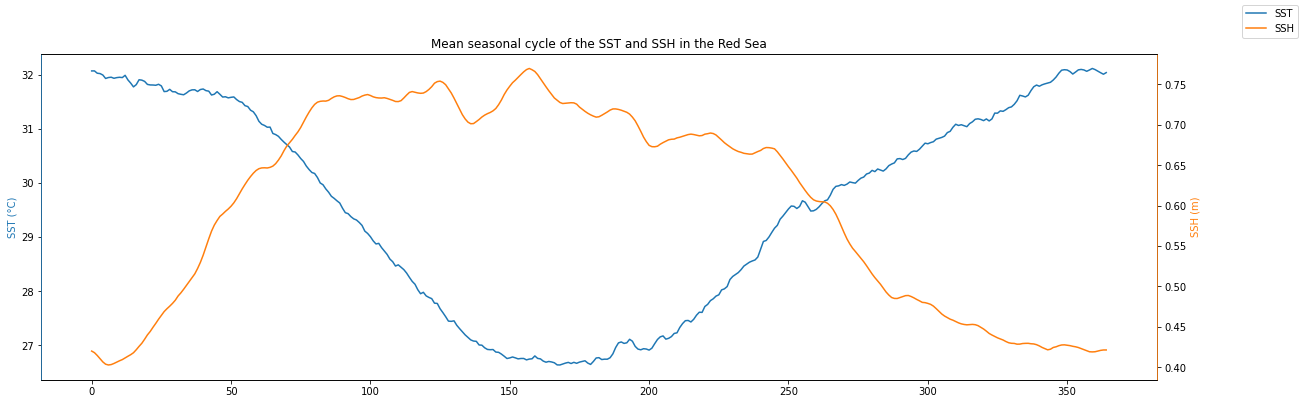

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,6))

ax1.plot(output_5.f0_.to_numpy(), output_5.avg_sst.to_numpy(), color="C0")
ax1.set_title('Mean seasonal cycle of the SST and SSH in the Red Sea')
ax1.set_ylabel('SST (°C)', color='C0')

ax2 = ax1.twinx()
ax2.plot(output_5.f0_.to_numpy(), output_5.avg_ssh.to_numpy(), color="C1")
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_color('C0')
ax2.set_ylabel('SSH (m)', color='C1')
fig.legend(['SST','SSH'])
plt.show()

**Part 6)**

In the global Ocean, count the number of values exceeding the threshold SSH > 1.5m. Plot in space and time.

In [ ]:
%%bigquery output_6 --project alert-ground-261008
SELECT time, lon, lat, COUNT(ssh) as ssh_count
FROM bdo2020.bdo2020.1998_2015
WHERE ssh > 1.5
GROUP BY time, lon, lat

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
spaceThreshold = output_6.groupby(by=["lon", "lat"], as_index=False).sum()

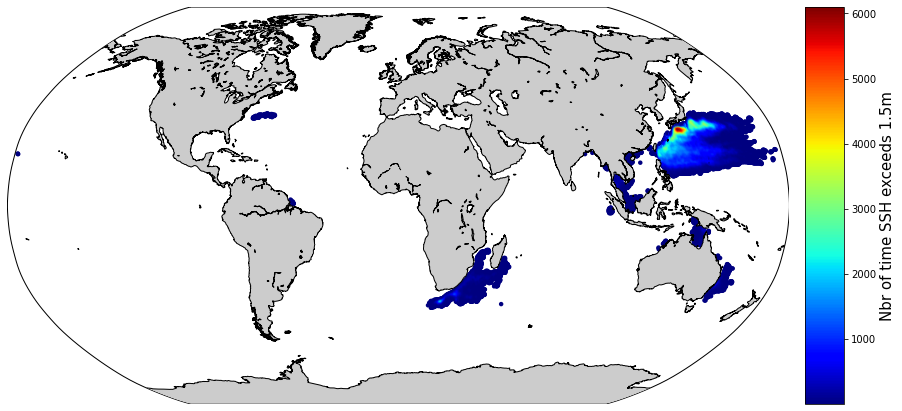

In [ ]:
plot_im(spaceThreshold.lon, spaceThreshold.lat, spaceThreshold.ssh_count, 20, "Nbr of times SSH exceeds 1.5m")

In [ ]:
timeThreshold = output_6.groupby(by=["time"], as_index=False).sum()
timeThreshold.sort_values("time", inplace=True)

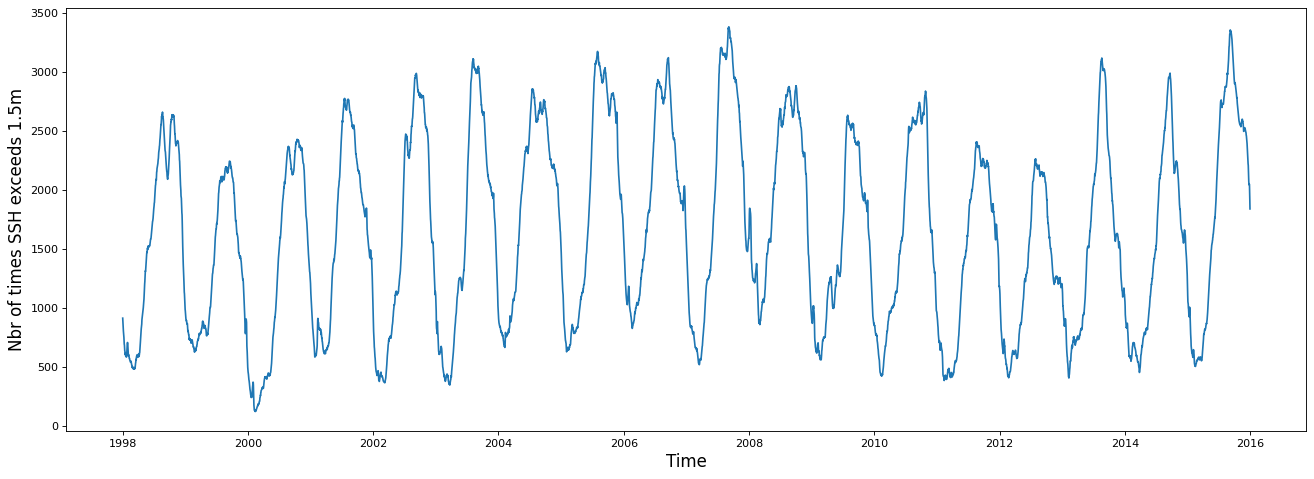

In [ ]:
figure(figsize=(20, 7), dpi=80)
plot_ts(timeThreshold.time.to_numpy(), timeThreshold.ssh_count.to_numpy(), "-", "Nbr of times SSH exceeds 1.5m")

**Part 7)**

In the Gulf of Mexico (`270<lon<274; 24<lat<28`), plot evolution in time of sst/ssh correlation.

In [ ]:
%%bigquery output_7 --project alert-ground-261008
SELECT dayofyear, CORR(sst, ssh) as sst_ssh_corr
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lat>24 AND lat<28 AND lon>270 AND lon<274
GROUP BY dayofyear
ORDER BY dayofyear ASC

Query is running:   0%|          |

Downloading:   0%|          |

Text(0.5, 1.0, 'Corr between SST and SSH over time of Gulf of Mexico')

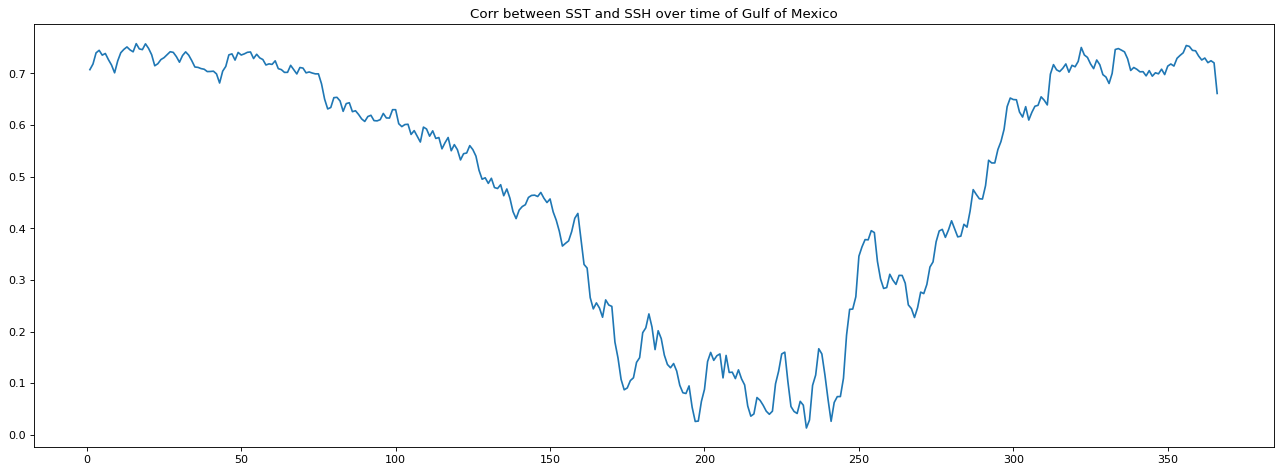

In [ ]:
figure(figsize=(20, 7), dpi=80)
plt.plot(output_7.dayofyear.to_list(), output_7.sst_ssh_corr, "-")
plt.title("Corr between SST and SSH over time of Gulf of Mexico")